In [168]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import featuretools as ft
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

%matplotlib inline
RSEED = 50

# Load Original Features

In [183]:
feat_num = 457

In [184]:
df_total = pd.read_csv('./data/features%s.csv'%(feat_num))

In [185]:
features_train = df_total[df_total['isFraud'].notnull()]
features_test = df_total[df_total['isFraud'].isnull()]

In [186]:
labels_train = features_train['isFraud']
features_train = features_train.drop(columns = ['isFraud', 'TransactionID'])

In [187]:
features_train.shape

(590540, 455)

# Prepare model

In [188]:
categorical = ['ProductCD', 'card2', 'card3', 'card4', 'card5','card6',
              'addr1','addr2','P_email','R_email','M1','M2','M3',
              'M4','M5','M6','M7','M8','M9','DeviceType','DeviceInfo','dow','hour',
              'Device_name','Device_version','screen_width','screen_height',
               'P_email_suffix','R_email_suffix','id_30_OS','id_30_version']
ids = [ 'id_%s'%(i) for i in range(12,39)]
categorical = categorical + ids

In [189]:
categorical = list(set(categorical).intersection(df_total.columns))

In [190]:
features_test_new = features_test.drop(columns = ['isFraud', 'TransactionID'])

In [191]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
          #'is_unbalance':True
          #'scale_pos_weight':9
         }

# Feature Selection

In [192]:
features_train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_02_to_std_card1,D15_to_mean_card1,D15_to_std_card1,D15_to_mean_addr1,D15_to_std_addr1,TransactionAmt_decimal,Device_name,Device_version,screen_width,screen_height
0,86400,68.5,0,13926,NaN,150.0,0,142.0,0,315.0,...,NaN,0.000000,0.000000,0.000000,0.000000,500,-1,-1,-1,-1
1,86401,29.0,0,2755,404.0,150.0,1,102.0,0,325.0,...,NaN,0.000000,0.000000,0.000000,0.000000,0,-1,-1,-1,-1
2,86469,59.0,0,4663,490.0,150.0,2,166.0,1,330.0,...,NaN,2.188598,1.578656,1.420777,1.251501,0,-1,-1,-1,-1
3,86499,50.0,0,18132,567.0,150.0,1,117.0,1,476.0,...,NaN,0.471748,0.434842,0.581165,0.474049,0,-1,-1,-1,-1
4,86506,50.0,1,4497,514.0,150.0,1,102.0,0,420.0,...,0.9245,NaN,NaN,NaN,NaN,0,0,0,0,0


In [193]:
train_set = lgb.Dataset(features_train.iloc[0:472432,:], label=labels_train.values[0:472432],
                       categorical_feature=categorical)
valid_set = lgb.Dataset(features_train.iloc[472432:,:], label=labels_train.values[472432:],
                       categorical_feature=categorical)
model = lgb.train(params,train_set,num_boost_round = 10000, 
                   valid_sets = [train_set, valid_set],
                    verbose_eval=500,
                    early_stopping_rounds = 500)

/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.987542	valid_1's auc: 0.9208
[1000]	training's auc: 0.99847	valid_1's auc: 0.928556
[1500]	training's auc: 0.999877	valid_1's auc: 0.929019
Early stopping, best iteration is:
[1330]	training's auc: 0.999691	valid_1's auc: 0.929165


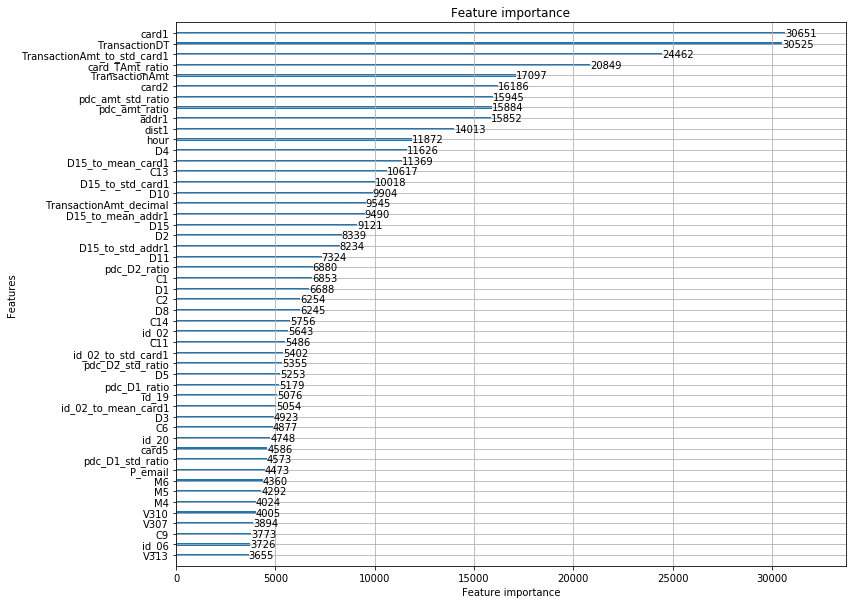

In [194]:
lgb.plot_importance(model, max_num_features=50,figsize=(12,10))

In [134]:
fi = pd.DataFrame({'feature': features_train.columns, 
                   'importance':model.feature_importance()})
fi = fi.sort_values('importance', ascending = False)

In [136]:
fi_important = fi.iloc[0:200,:]
features_train = features_train[fi_important.feature]
features_test_new = features_test[fi_important.feature]
categorical = list(set(categorical).intersection(fi_important.feature))

# Train Model

In [195]:
splits = 5
folds = KFold(n_splits = splits,random_state=RSEED)
predictions = np.zeros(len(features_test_new))

In [196]:
for fold_num, (trn_idx, val_idx) in enumerate(folds.split(features_train.values, 
                                                          labels_train.values)):
    print("Fold {}".format(fold_num))
    train_df, y_train_df = features_train.iloc[trn_idx], labels_train.iloc[trn_idx]
    valid_df, y_valid_df = features_train.iloc[val_idx], labels_train.iloc[val_idx]
    
    trn_data = lgb.Dataset(train_df, label=y_train_df,categorical_feature=categorical)
    val_data = lgb.Dataset(valid_df, label=y_valid_df,categorical_feature=categorical)
    
    clf = lgb.train(params,
                    trn_data,
                    10000,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds=500)

    pred = clf.predict(valid_df)
    print( "  auc = ", roc_auc_score(y_valid_df, pred) )
    predictions += clf.predict(features_test_new) / splits

Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.987266	valid_1's auc: 0.906853
[1000]	training's auc: 0.99823	valid_1's auc: 0.917408
[1500]	training's auc: 0.999827	valid_1's auc: 0.920038
[2000]	training's auc: 0.99999	valid_1's auc: 0.921498
[2500]	training's auc: 1	valid_1's auc: 0.92192
[3000]	training's auc: 1	valid_1's auc: 0.922329
[3500]	training's auc: 1	valid_1's auc: 0.922692
Early stopping, best iteration is:
[3377]	training's auc: 1	valid_1's auc: 0.922661
  auc =  0.9226612410592332
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.988032	valid_1's auc: 0.929418
[1000]	training's auc: 0.998581	valid_1's auc: 0.936872
[1500]	training's auc: 0.999883	valid_1's auc: 0.93782
Early stopping, best iteration is:
[1435]	training's auc: 0.999835	valid_1's auc: 0.937863
  auc =  0.9378627432051435
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.988731	valid_1's auc: 0.92744
[1000]	training's auc: 0.998625	valid_1's auc: 0.932798
[1500]	training's auc: 0.99989	valid_1's auc: 0.932987
[2000]	training's auc: 0.999996	valid_1's auc: 0.933119
[2500]	training's auc: 1	valid_1's auc: 0.933395
[3000]	training's auc: 1	valid_1's auc: 0.93358
[3500]	training's auc: 1	valid_1's auc: 0.933822
Early stopping, best iteration is:
[3072]	training's auc: 1	valid_1's auc: 0.933622
  auc =  0.9336216663938938
Fold 3


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.988	valid_1's auc: 0.944243
[1000]	training's auc: 0.998571	valid_1's auc: 0.952256
[1500]	training's auc: 0.999887	valid_1's auc: 0.953023
[2000]	training's auc: 0.999995	valid_1's auc: 0.952968
Early stopping, best iteration is:
[1737]	training's auc: 0.999972	valid_1's auc: 0.95309
  auc =  0.9530899870617591
Fold 4


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.987542	valid_1's auc: 0.9208
[1000]	training's auc: 0.99847	valid_1's auc: 0.928556
[1500]	training's auc: 0.999877	valid_1's auc: 0.929019
Early stopping, best iteration is:
[1330]	training's auc: 0.999691	valid_1's auc: 0.929165
  auc =  0.9291645460192598


In [197]:
id_test = features_test['TransactionID']
submission = pd.DataFrame({'TransactionID': id_test, 
                            'isFraud': predictions})
submission.to_csv('./data/sub_feat%s_modelselect.csv'%(feat_num), index = False)